In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [29]:
df_train = pd.read_excel("AI_vs_huam_train_dataset.xlsx")
df_test = pd.read_csv("Final_test_data.csv")

In [36]:
from nltk.corpus import wordnet
from nltk import pos_tag

def get_wordnet_pos_tag(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


def text_process(tweet):
  if not isinstance(tweet, str) or not tweet.strip():
        return ""

  try:
      lemmatizer = WordNetLemmatizer()
      stop_words = set(stopwords.words('english'))

      tweet = tweet.lower()

      tweet = tweet.translate(str.maketrans('', '', string.punctuation + string.digits))

      tokens = word_tokenize(tweet)

      pos_tags = pos_tag(tokens)

      processed_tokens = []
      for word, tag in pos_tags:
          if len(word) > 1 and word not in stop_words:
              pos = get_wordnet_pos_tag(tag)
              lemma = lemmatizer.lemmatize(word, pos=pos)
              processed_tokens.append(lemma)

      return " ".join(processed_tokens)

  except Exception as e:
      print(f"处理文本时出错: {e}")
      return ""

In [37]:
df_train['lematized_tweets'] = df_train['essay'].apply(text_process)
df_test['lematized_tweets'] = df_test['essay'].apply(text_process)

print(df_train.head())
print(df_test.head())

                                               essay  label  \
0  International sports events require the most w...      0   
1  Globalisation has become a significant aspect ...      0   
2  There is an ever-increasing number of bullying...      0   
3  It is commonly believed, that companies should...      0   
4  Despite knowing about the adverse effects of c...      0   

                                    lematized_tweets  
0  international sport event require welltrained ...  
1  globalisation become significant aspect world ...  
2  everincreasing number bully activity numerous ...  
3  commonly believe company dress code policy emp...  
4  despite know adverse effect climate change hum...  
                                               essay  label  \
0  Enjoyment means entertainment, satisfaction of...    NaN   
1  Before to start with my opinion of the topic i...    NaN   
2  Thats a really really good subject, but acctul...    NaN   
3  I disagree with the statement saying

In [44]:
X = df_train['lematized_tweets']
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
svc_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC(probability=True))
])

svm_param_grid = {
    # 'vectorizer__max_features': [1000, 5000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__C': [0.1, 1, 10],
    # 'classifier__gamma': ['scale', 'auto', 0.001, 0.01],
    'classifier__kernel': ['linear', 'rbf']
}

svm_grid_search = GridSearchCV(
    svc_pipeline,
    svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

svm_grid_search.fit(X_train, y_train)

svm_best_pipe = svm_grid_search.best_estimator_

print("Best estimator for SVM:" , svm_best_pipe)

Best estimator for SVM: Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(C=10, kernel='linear', probability=True))])


In [40]:
dt_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier())
])

dt_param_grid = {
    # 'vectorizer__max_features': [3000, 5000, 7000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    # 'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

dt_grid_search.fit(X_train, y_train)

dt_best_pipe = dt_grid_search.best_estimator_

print("Best estimator for Decision Tree:" , dt_best_pipe)

Best estimator for Decision Tree: Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', DecisionTreeClassifier(min_samples_leaf=2))])


In [41]:
ada_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', AdaBoostClassifier())
])

ada_param_grid = {
    # 'vectorizer__max_features': [3000, 5000, 7000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}

ada_grid_search = GridSearchCV(
    ada_pipeline,
    ada_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

ada_grid_search.fit(X_train, y_train)

ada_best_pipe = ada_grid_search.best_estimator_

In [45]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

def run_cross_validation(model, X, y):
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)
  k_scores = cross_val_score(model, X, y, cv=kfold, scoring = 'accuracy')

  results = []
  results.append({
      'K Mean Accuray': np.mean(k_scores),
      'KFold Score': k_scores
  })

  skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  sk_scores = cross_val_score(model, X, y, cv=skfold, scoring = 'accuracy')
  results = []
  results.append({
      'SK Mean Accuray': np.mean(sk_scores),
      'SKFold Score': sk_scores
  })

  return pd.DataFrame(results)

svm_cv = run_cross_validation(svm_best_pipe, X_train, y_train)
dt_cv = run_cross_validation(dt_best_pipe, X_train, y_train)

cv_results = pd.concat([svm_cv, dt_cv], axis=1)
print(cv_results)

   SK Mean Accuray                                       SKFold Score  \
0         0.978873  [0.9782244556113903, 0.9798994974874372, 0.974...   

   SK Mean Accuray                                       SKFold Score  \
0         0.902415  [0.9195979899497487, 0.8844221105527639, 0.889...   

   SK Mean Accuray                                       SKFold Score  
0         0.973173  [0.9765494137353434, 0.966499162479062, 0.9781...  


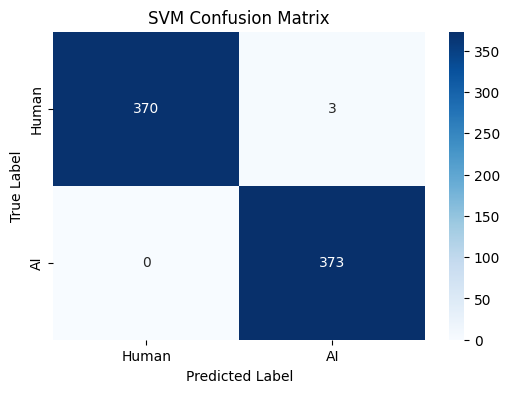

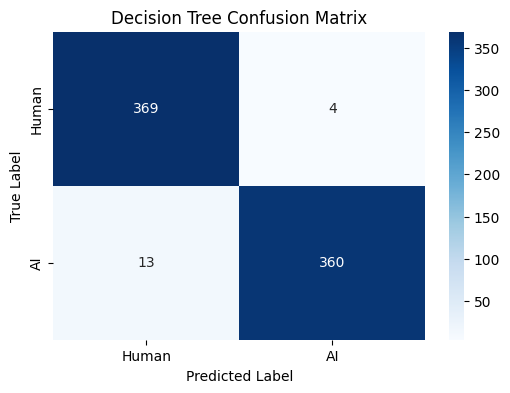

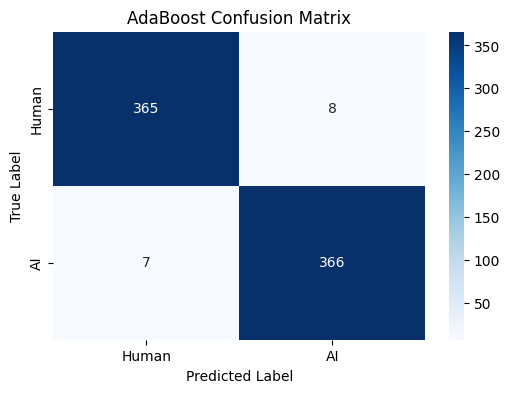

In [47]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           RocCurveDisplay, PrecisionRecallDisplay)


def evaluate_model(model, X, y, model_name):
  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None

  metrics = {
    'Accuracy': accuracy_score(y, y_pred),
    'Precision (macro)': precision_score(y, y_pred, average='macro'),
    'Recall (macro)': recall_score(y, y_pred, average='macro'),
    'F1 (macro)': f1_score(y, y_pred, average='macro'),
    'Precision (weighted)': precision_score(y, y_pred, average='weighted'),
    'Recall (weighted)': recall_score(y, y_pred, average='weighted'),
    'F1 (weighted)': f1_score(y, y_pred, average='weighted'),
    'ROC AUC': roc_auc_score(y, y_proba) if y_proba is not None else 'N/A'
  }

  cm = confusion_matrix(y, y_pred)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Human', 'AI'],
              yticklabels=['Human', 'AI'])
  plt.title(f'{model_name} Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  return metrics

val_metrics = {
    'SVM': evaluate_model(svm_best_pipe, X_test, y_test, 'SVM'),
    'Decision Tree': evaluate_model(dt_best_pipe, X_test, y_test, 'Decision Tree'),
    'AdaBoost': evaluate_model(ada_best_pipe, X_test, y_test, 'AdaBoost')
}

               Accuracy  Precision (macro)  Recall (macro)  F1 (macro)  \
SVM              0.9960             0.9960          0.9960      0.9960   
Decision Tree    0.9772             0.9775          0.9772      0.9772   
AdaBoost         0.9799             0.9799          0.9799      0.9799   

               Precision (weighted)  Recall (weighted)  F1 (weighted)  ROC AUC  
SVM                          0.9960             0.9960         0.9960   0.9999  
Decision Tree                0.9775             0.9772         0.9772   0.9889  
AdaBoost                     0.9799             0.9799         0.9799   0.9993  


<Figure size 1000x500 with 0 Axes>

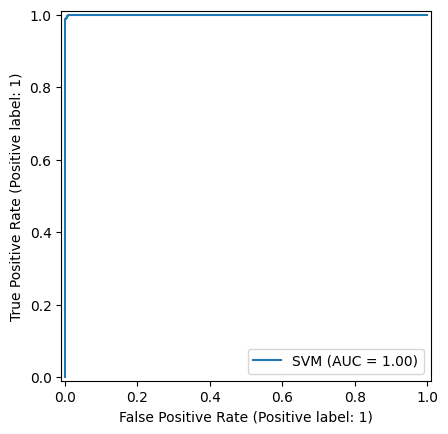

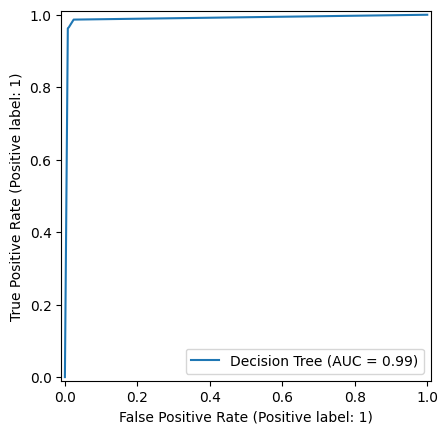

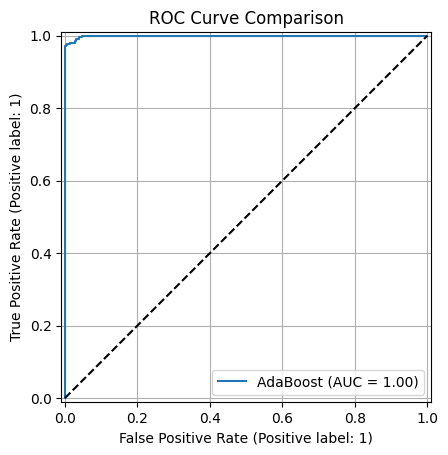

<Figure size 1000x500 with 0 Axes>

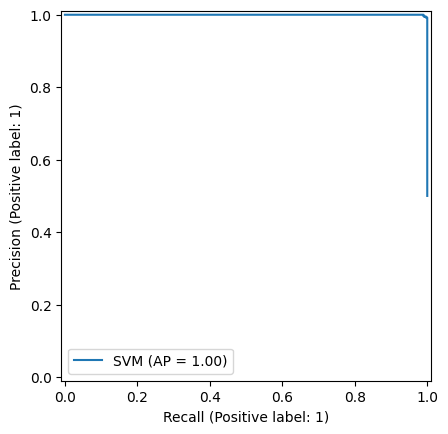

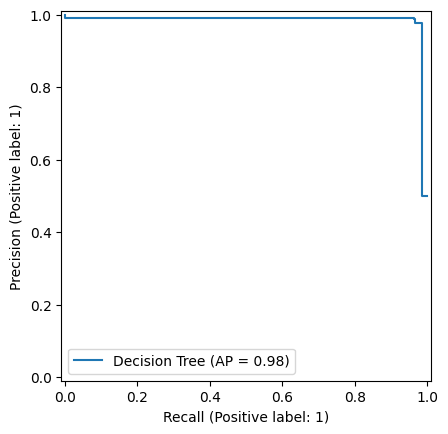

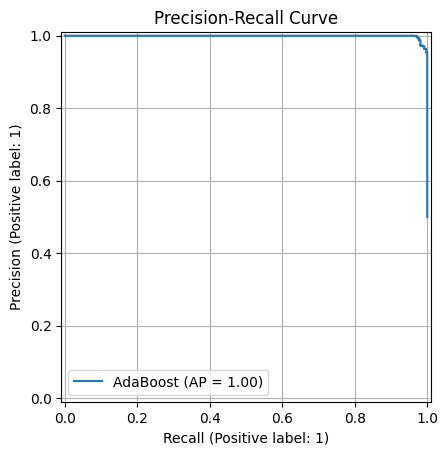

In [48]:
comparision_df = pd.DataFrame(val_metrics).T.round(4)
print(comparision_df)

plt.figure(figsize=(10, 5))
RocCurveDisplay.from_estimator(svm_best_pipe, X_test, y_test, name='SVM')
RocCurveDisplay.from_estimator(dt_best_pipe, X_test, y_test, name='Decision Tree')
RocCurveDisplay.from_estimator(ada_best_pipe, X_test, y_test, name='AdaBoost')
plt.title('ROC Curve Comparison')
plt.plot([0, 1], [0, 1], 'k--')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
PrecisionRecallDisplay.from_estimator(svm_best_pipe, X_test, y_test, name='SVM')
PrecisionRecallDisplay.from_estimator(dt_best_pipe, X_test, y_test, name='Decision Tree')
PrecisionRecallDisplay.from_estimator(ada_best_pipe, X_test, y_test, name='AdaBoost')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [50]:
import joblib
joblib.dump(svm_best_pipe, 'svm_pipeline.pkl')
joblib.dump(dt_best_pipe, 'dt_pipeline.pkl')
joblib.dump(ada_best_pipe, 'ada_pipeline.pkl')

['ada_pipeline.pkl']